<a href="https://colab.research.google.com/github/fralfaro/MAT281_2022/blob/main/homeworks/h2/hw_02.ipynb
" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tarea N°02

## Instrucciones

1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.


* __Nombre__: Juan Vásquez

* __Rol__: 201604608-9

2.- Debes _subir_ este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:
   - Soluciones
   - Código
   - Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [9]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from metrics_classification import *
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

import timeit
import time

%matplotlib inline

In [10]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [11]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [12]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [13]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

In [14]:
digits.drop("target", axis = 1, inplace = False) # no es necesario utilizar la columa target
digits.describe()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


¿Cómo se distribuyen los datos?

Para estudiar como se distribuyen los datos se grafican las 64 columnas, en 8 filas y 8 columnas sin contar la columna target, que se grafica por separado.

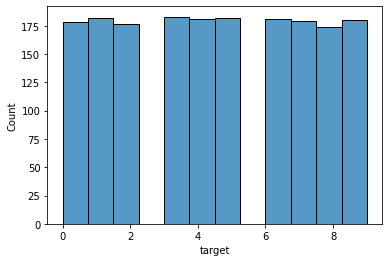

In [15]:
fig = figsize = (20,20)
sns.histplot(digits[digits.columns[64]])
plt.show()

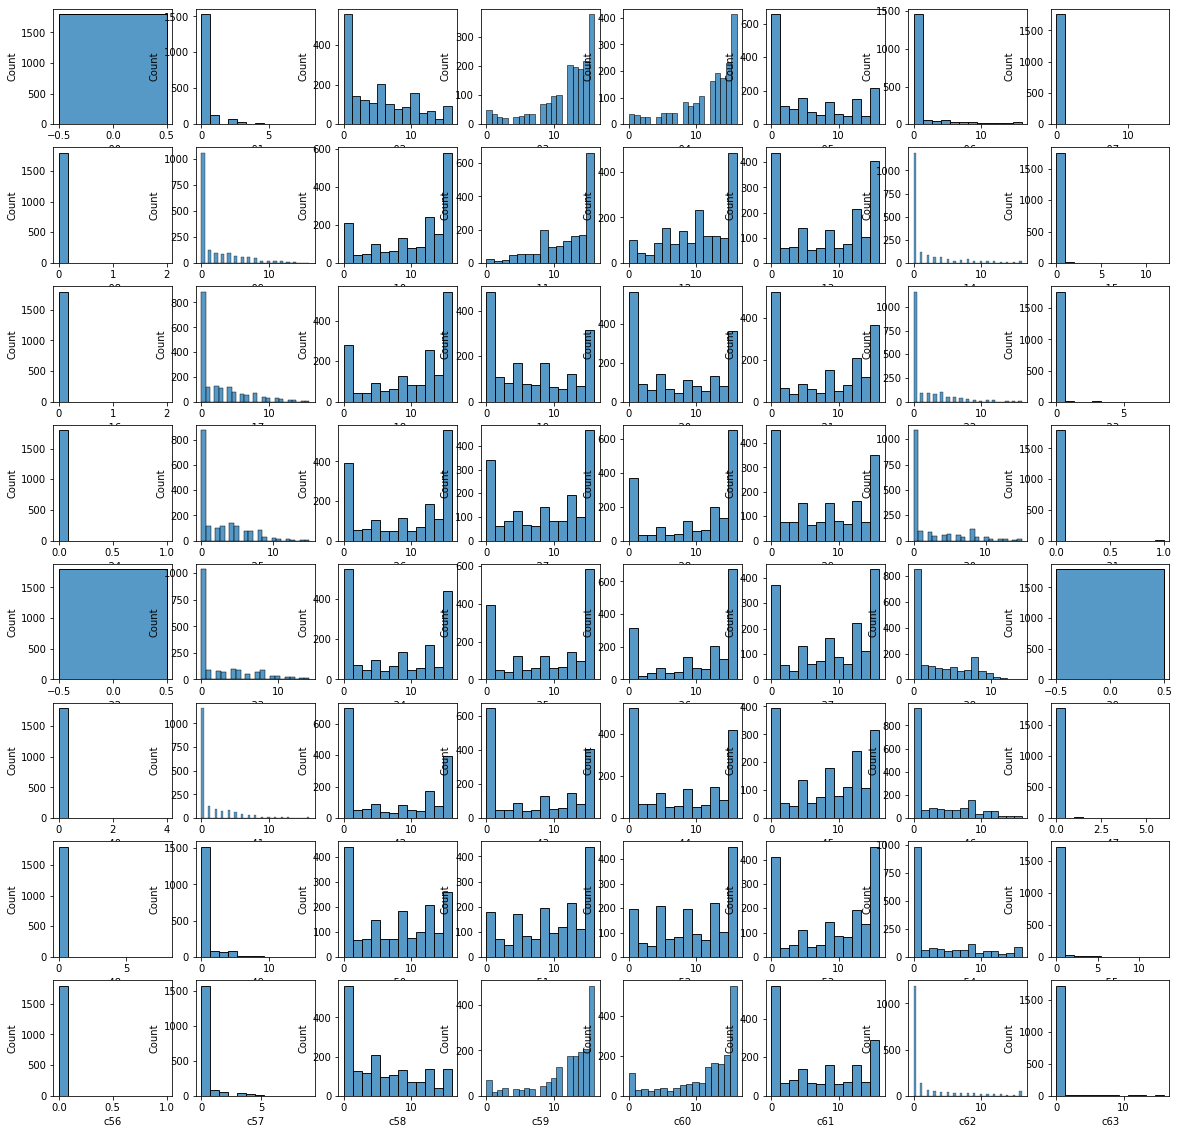

In [16]:
fig, axs = plt.subplots(8,8, figsize = (20,20))

for i in range(0,64): 
    plt.subplot(8,8,i+1)
    sns.histplot(digits[digits.columns[i]])

Memoria a utilizar

In [17]:
print(digits.memory_usage().sum(), "bytes")

934568 bytes


Tipo de datos

In [18]:
digits.dtypes.unique()

array([dtype('int64')], dtype=object)

Todos los datos son números enteros.
¿Cuántos registros por clase hay?

In [19]:
digits.shape

(1797, 65)

Vemos que hay 1797 registros, correspondiente al número de filas

¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

In [20]:
digits.isnull().values.any()

False

No hay registros nulos, además todos son números enteros

### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [21]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

> **Sugerencia**: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

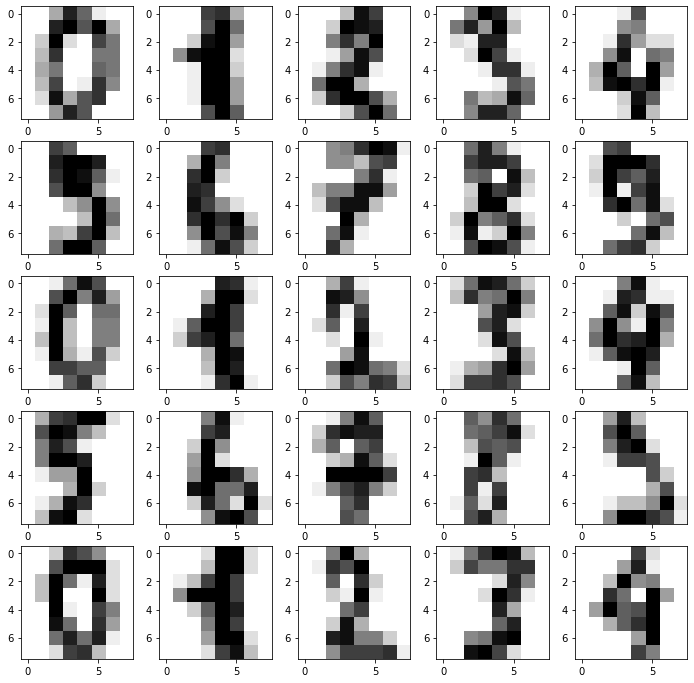

In [22]:
nx, ny = 5, 5
fig, axs = plt.subplots(nx, ny, figsize=(12, 12))
for i in range(0,25):  # para ver una matriz de 5x5, recorrer de 0 a 25
    plt.subplot(nx,ny,i+1)
    plt.imshow(digits_dict["images"][i],cmap='gray_r') 

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from metrics_classification import *
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_digits
from sklearn.model_selection import validation_curve
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA


from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

selección de parámetros para entrenar y pruebas

In [24]:
X = digits.drop(columns="target").values
y = digits["target"].values
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [25]:
# print rows train and test sets
print('Separando informacion:\n')
print('numero de filas data original : ',len(X))
print('numero de filas train set     : ',len(X_train))
print('numero de filas test set      : ',len(X_test))

Separando informacion:

numero de filas data original :  1797
numero de filas train set     :  1257
numero de filas test set      :  540


**Modelo de Regresión logística**

In [26]:
model = LogisticRegression() # aplica el modelo
param_grid1 = {'penalty': ['l1', 'l2', 'elasticnet'], 'C':[0.01,0.1,1,10]} # rango de parámetros
gs_m1 = GridSearchCV(estimator=model, 
                  param_grid=param_grid1) # optimización hiperparámetro
gs_m1 = gs_m1.fit(X_train, Y_train)

print("Best: %f con %s" % (gs_m1.best_score_, gs_m1.best_params_))

Best: 0.957032 con {'C': 0.01, 'penalty': 'l2'}


In [27]:
modelo1 = gs_m1.best_estimator_ # elige el mejor modelo
print('Precisión: {0:.3f}'.format(modelo1.score(X_test, Y_test)))

Precisión: 0.970


In [28]:
Y_pred = modelo1.predict(X_test)

print(confusion_matrix(Y_test,Y_pred))
df1 = pd.DataFrame({'y': Y_test,'yhat': Y_pred})

print('\n Las métricas son:')
summary_metrics(df1)

[[53  0  0  0  0  0  0  0  0  0]
 [ 0 46  2  0  0  0  0  0  2  0]
 [ 0  0 47  0  0  0  0  0  0  0]
 [ 0  0  0 51  0  1  0  0  2  0]
 [ 0  1  0  0 59  0  0  0  0  0]
 [ 0  0  1  0  0 63  1  0  0  1]
 [ 0  0  0  0  0  1 52  0  0  0]
 [ 0  0  0  0  0  0  0 54  0  1]
 [ 0  0  0  0  0  1  0  0 42  0]
 [ 0  0  0  1  0  0  0  0  1 57]]

 Las métricas son:


,accuracy,recall,precision,fscore
0,0.9704,0.9708,0.9695,0.9697


**Modelo K-Nearest Neighbors**

In [29]:
model2 = KNeighborsClassifier() # modelo 2
param_grid2 = {'n_neighbors':[0.01,0.1,1,10]}
gs_m2 = GridSearchCV(estimator=model2, 
                  param_grid=param_grid2) # hiperparámetros

gs_m2 = gs_m2.fit(X_train, Y_train)
print("Best: %f con %s" % (gs_m2.best_score_, gs_m2.best_params_))

Best: 0.986476 con {'n_neighbors': 1}


In [30]:
modelo2 = gs_m2.best_estimator_ # elige mejor modelo
print('Precisión: {0:.3f}'.format(modelo2.score(X_test, Y_test)))

Precisión: 0.983


In [31]:
Y_pred = modelo2.predict(X_test)

print(confusion_matrix(Y_test,Y_pred))
df2 = pd.DataFrame({'y': Y_test,'yhat': Y_pred})

print('\n Las métricas son:')
summary_metrics(df2)

[[53  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 47  0  0  0  0  0  0  0]
 [ 0  0  0 53  0  0  0  0  1  0]
 [ 0  1  0  0 59  0  0  0  0  0]
 [ 0  0  0  0  0 65  0  0  0  1]
 [ 0  0  0  0  0  0 53  0  0  0]
 [ 0  0  0  0  0  0  0 54  0  1]
 [ 0  1  0  0  0  0  0  0 41  1]
 [ 0  0  0  2  1  0  0  0  0 56]]

 Las métricas son:


,accuracy,recall,precision,fscore
0,0.9833,0.9834,0.9834,0.9833


**Modelo SVC**

In [32]:
model3 = SVC()
param_grid3 = {'kernel':('linear', 'rbf'), 'C':[0.01,0.1,1,10]}
gs_m3 = GridSearchCV(estimator=model3, 
                  param_grid=param_grid3)
gs_m3 = gs_m3.fit(X_train, Y_train)
print("Best: %f con %s" % (gs_m3.best_score_, gs_m3.best_params_))


Best: 0.990460 con {'C': 10, 'kernel': 'rbf'}


In [33]:
modelo3 = gs_m3.best_estimator_
print('Precisión: {0:.3f}'.format(modelo3.score(X_test, Y_test)))

Precisión: 0.989


In [34]:
Y_pred = modelo3.predict(X_test)

print(confusion_matrix(Y_test,Y_pred))
df3 = pd.DataFrame({'y': Y_test,'yhat': Y_pred})

print('\n Las métricas son:')
summary_metrics(df3)

[[53  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 47  0  0  0  0  0  0  0]
 [ 0  0  1 52  0  1  0  0  0  0]
 [ 0  0  0  0 60  0  0  0  0  0]
 [ 0  0  0  0  0 65  0  0  0  1]
 [ 0  0  0  0  0  0 53  0  0  0]
 [ 0  0  0  0  0  0  0 54  0  1]
 [ 0  0  0  0  0  0  0  0 43  0]
 [ 0  0  0  0  0  0  0  1  1 57]]

 Las métricas son:


,accuracy,recall,precision,fscore
0,0.9889,0.9896,0.9889,0.9892


**¿Cuál modelo es mejor basado en sus métricas?**

Comparando las métricas anteriormente mostradas, el modelo SVC presenta las mejores métricas

**¿Cuál modelo demora menos tiempo en ajustarse?**

In [35]:
%timeit modelo1.fit(X_train, Y_train)
%timeit modelo2.fit(X_train, Y_train)
%timeit modelo3.fit(X_train, Y_train)

269 ms ± 20.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
243 µs ± 6.21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
42.5 ms ± 595 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


el modelo que menos tiempo tarda en ajustarse es el K-Nearest Neighbors

**¿Cuál modelo escoges?**

Si el tiempo no es problema, me quedaría con el modelo SVC ya que es el que tiene las mejores métricas

### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

Cross validation

In [36]:
precision = cross_val_score(estimator=model3,
                            X=X_train,
                            y=Y_train,
                            cv=10)

print('{0: .2f} +/- {1: .2f}'.format(np.mean(precision), np.mean(precision)))
print('{0: .2f} +/- {1: .2f}'.format(np.mean(precision), np.std(precision)))


 0.99 +/-  0.99
 0.99 +/-  0.01


Curva de validación

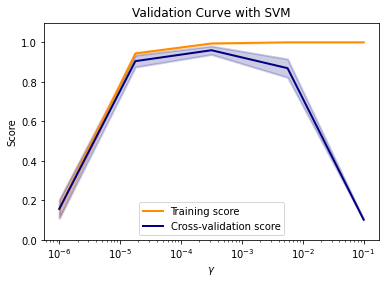

In [37]:
X, Y = load_digits(return_X_y=True)

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(),
    X,
    Y,
    param_name="gamma",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

Conclusiones:

Del gráfico se puede obtener que valor de gamma entrega el Score más alto. Un valor mediano de gamma muestra que para ambas curvas se obtiene un buen resultado, la elección de este valor de gamma indica que el clasificador se está desempeñando de buena manera. Un gamma muy bajo tiene un bajo puntaje en la curva de entrenamiento y de validación, por otro lado, un gamma alto tiene un buen entrenamiento pero un puntaje bajo de validación.

Receiver Operating Characteristic (ROC) with cross validation

In [38]:
# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)

# Binarize the output
y = label_binarize(Y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=random_state)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

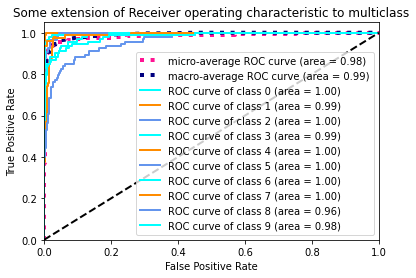

In [39]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

Conclusiones:

La mejor curva es la que presenta el área más grande, en el gráfico se muestra que varios clasificadores tiene un área de 1. La elección de cualquiera de ellas es un buen clasificador

### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


In [40]:
columns = digits.columns
lista = []
for i in columns:
    if digits[i].any() == False: # .any devuelve False si el valor es cero en todas sus filas
        lista.append(i)

print(lista)

['c00', 'c32', 'c39']


hay 3 columnas que tienen valores nulos en todas sus filas

In [41]:
# Selección de Columnas a entrenar usando la prueba F
X_train = digits.drop(['c00', 'c32', 'c39','target'], axis=1, inplace = False) # se borran las columnas con valores cero
Y_train = digits['target']
k = 22  # Número de atributos 
columnas = list(X_train.columns.values)
select = SelectKBest(f_classif, k=k).fit(X_train, Y_train).get_support()
atributos = [columnas[i] for i in list(select.nonzero()[0])]
atributos

['c02',
 'c10',
 'c13',
 'c20',
 'c21',
 'c26',
 'c27',
 'c28',
 'c30',
 'c33',
 'c34',
 'c36',
 'c38',
 'c42',
 'c43',
 'c44',
 'c46',
 'c53',
 'c54',
 'c58',
 'c60',
 'c61']

Tamaño del dataset

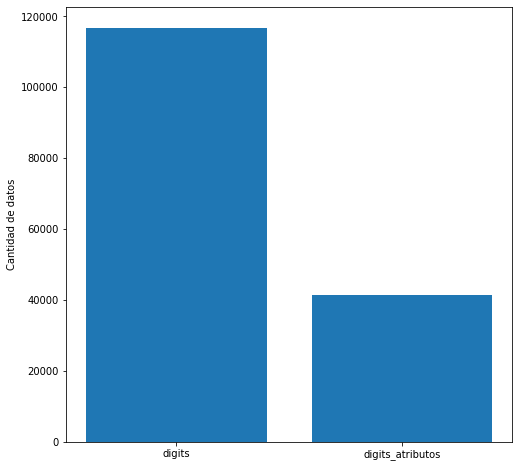

In [42]:
digits_atributos = digits[atributos + ['target']]
fig = plt.figure(figsize=(8,8))
plt.bar(x =["digits", "digits_atributos"], height = [digits.size,digits_atributos.size])
plt.ylabel("Cantidad de datos")
plt.show()

Tiempo de ejecución

In [43]:
# Data original
# División de los datos en train y test
X = digits.drop("target",axis = 1, inplace = False)
Y = digits["target"]

ti = time.time()
model3.fit(X_train, Y_train)
X_train, X_test, Y_train, Y_test = train_test_split(
                                        X,
                                        Y.values,
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
tf1 = time.time() - ti
print(tf1)

0.10119867324829102


In [44]:
# Data atributos
# División de los datos en train y test
X = digits_atributos.drop("target",axis = 1, inplace = False)
Y = digits["target"]

ti = time.time()
model3.fit(X_train, Y_train)
X_train, X_test, Y_train, Y_test = train_test_split(
                                        X,
                                        Y.values,
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
tf2 = time.time() - ti
print(tf2)

0.05121278762817383


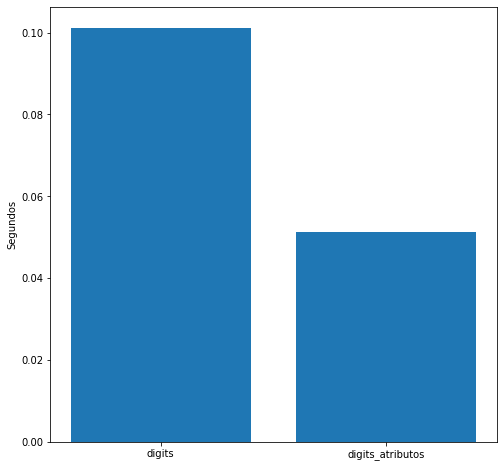

In [45]:
fig = plt.figure(figsize=(8,8))
plt.bar(x = ['digits', 'digits_atributos'], height = [tf1,tf2])
plt.ylabel('Segundos')
plt.show()

**Extracción de atributos:**

In [46]:
# Estandarización de datos usando StandardScaler

x = digits.drop("target",axis =1).values
y = digits["target"].values
x = StandardScaler().fit_transform(x)

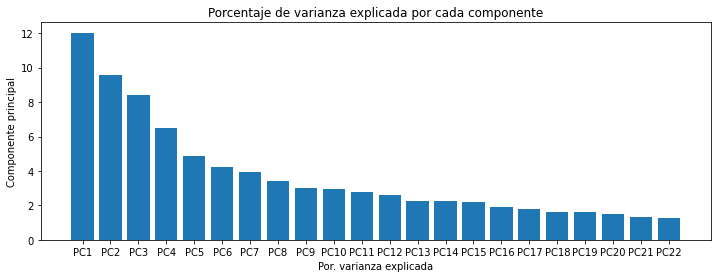

In [47]:
n_components = 22
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(x)

# graficar varianza por componente
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = [f"PC{i}" for i in range(1,n_components+1)]

plt.figure(figsize=(12,4))
plt.bar(x= range(1,n_components+1), height=percent_variance, tick_label=columns)

plt.ylabel('Componente principal')
plt.xlabel('Por. varianza explicada')
plt.title('Porcentaje de varianza explicada por cada componente')
plt.show()

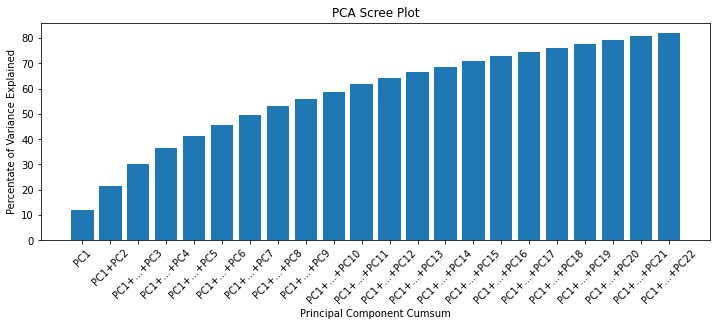

In [48]:
# graficar varianza por la suma acumulada de los componente
percent_variance_cum = np.cumsum(percent_variance)
columns_sum =[f"PC1+...+PC{i+1}" for i in range(2,n_components)]
columns_sum = ["PC1", "PC1+PC2"] + columns_sum

plt.figure(figsize=(12,4))
plt.bar(x= range(1,n_components+1), height=percent_variance_cum, tick_label=columns_sum)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component Cumsum')
plt.xticks(rotation =45)
plt.title('PCA Scree Plot')
plt.show()

In [49]:
df_princ = pd.DataFrame(data = principalComponents, columns = columns)
targetDataframe = digits[['target']]

digits_pca = pd.concat([df_princ, targetDataframe],axis = 1)
digits_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,target
0,1.914213,-0.954510,-3.946028,2.028735,-0.266995,0.530428,-1.415301,1.495791,0.125530,-0.821750,...,-0.193366,0.838240,0.109157,0.185335,-0.092783,0.413233,0.434184,0.461682,0.574602,0
1,0.588979,0.924622,3.924774,-1.779822,-0.993578,-0.675852,1.879179,0.556017,1.079370,0.086506,...,-0.392646,-0.748210,-0.209033,-0.112709,-0.430245,0.567006,-0.075572,0.899920,-0.247847,1
2,1.302040,-0.317166,3.023322,-2.043397,-2.081063,0.935259,-1.296756,1.156172,0.785521,-1.098767,...,-0.991568,-1.169467,0.398320,-0.219852,-0.459422,-1.072691,-1.125088,-0.532292,0.106043,2
3,-3.020770,-0.868769,-0.801760,-2.187054,-0.556635,0.727315,0.959484,-1.382626,0.260267,0.745794,...,1.009035,-0.138874,-1.001126,-0.945194,-0.391941,1.482338,0.313833,0.574345,-0.188649,3
4,4.528948,-1.093479,0.973124,-1.419497,-1.715187,1.431480,1.073774,-0.968339,-1.660643,1.173719,...,-0.114322,0.730998,0.211458,-0.091410,-0.550574,1.622753,1.085979,0.483189,-0.176799,4


Número de elementos

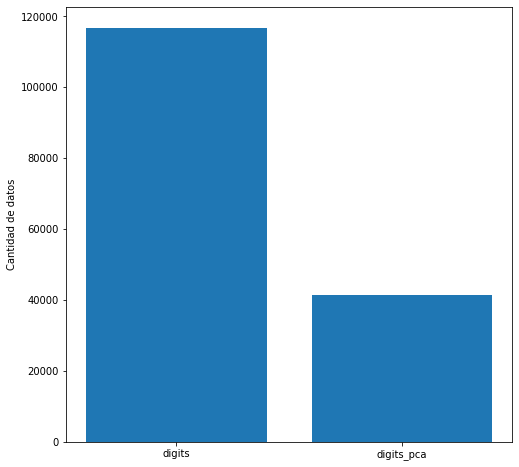

In [50]:
fig = plt.figure(figsize=(8,8))
plt.bar(x =["digits", "digits_pca"], height = [digits.size, digits_pca.size])
plt.ylabel("Cantidad de datos")
plt.show()

Tiempo de ejecución

In [51]:
# Data original
# División de los datos en train y test
X = digits.drop("target",axis = 1, inplace = False)
Y = digits["target"]

ti = time.time()
model3.fit(X_train, Y_train)
X_train, X_test, Y_train, Y_test = train_test_split(
                                        X,
                                        Y.values,
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
tf1 = time.time() - ti
print(tf1)

0.04816031455993652


In [52]:
# Data PCA
# División de los datos en train y test
X = digits_pca.drop("target",axis=1, inplace = False)
Y = digits["target"]

ti = time.time()
model3.fit(X_train, Y_train)
X_train, X_test, Y_train, Y_test = train_test_split(
                                        X,
                                        Y.values,
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
tf2 = time.time() - ti
print(tf2)

0.056388139724731445


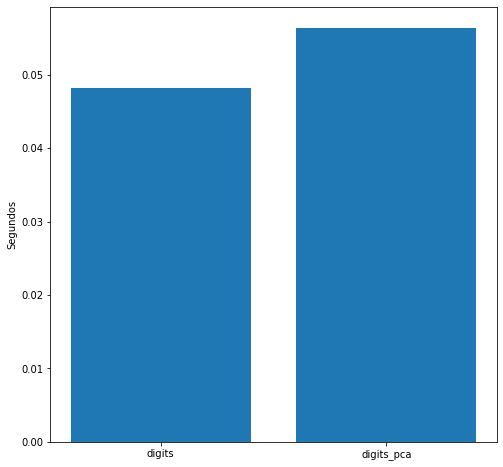

In [53]:
fig = plt.figure(figsize=(8,8))
plt.bar(x = ['digits', 'digits_pca'], height = [tf1,tf2])
plt.ylabel('Segundos')
plt.show()

### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [54]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    # habían algunos y en minúscula y otros en mayúsculas, se cambiaron todos a mayúscula
    
    X = digits.drop(columns="target").values
    Y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    Y_pred = model.predict(X_test)
    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = (Y_pred == Y_test)
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = (Y_pred != Y_test)
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    X_aux = X_test[mask]
    Y_aux_true = Y_test[mask]
    Y_aux_pred = Y_pred[mask]

    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            if index < X_aux.shape[0]:
                data  = X_aux[index, :].reshape(8,8)
                label_pred = str(int(Y_aux_pred[index]))
                label_true = str(int(Y_aux_true[index]))
                ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
                ax[i][j].text(0, 0, label_pred, horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
                ax[i][j].text(7, 0, label_true, horizontalalignment='center', verticalalignment='center', fontsize=10, color='blue')
                ax[i][j].get_xaxis().set_visible(False)
                ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

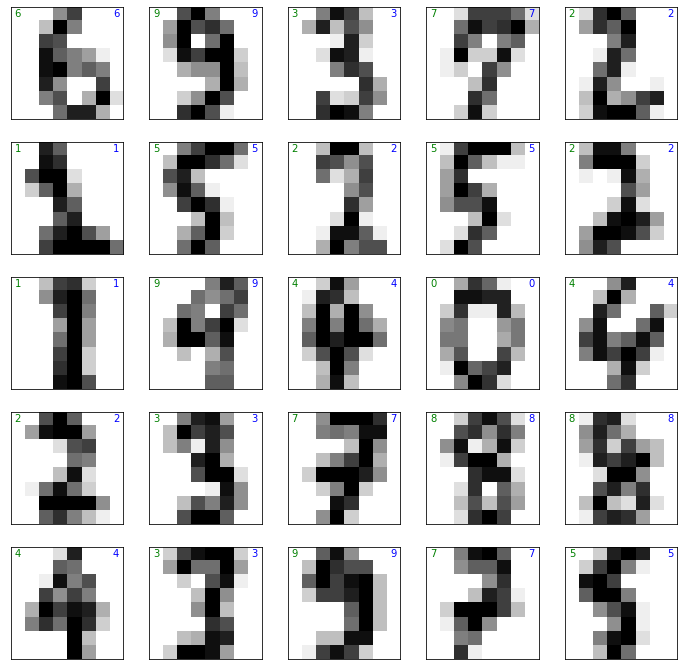

In [55]:
model = gs_m3
mostar_resultados(digits, model = model ,nx=5, ny=5,label = "correctos")

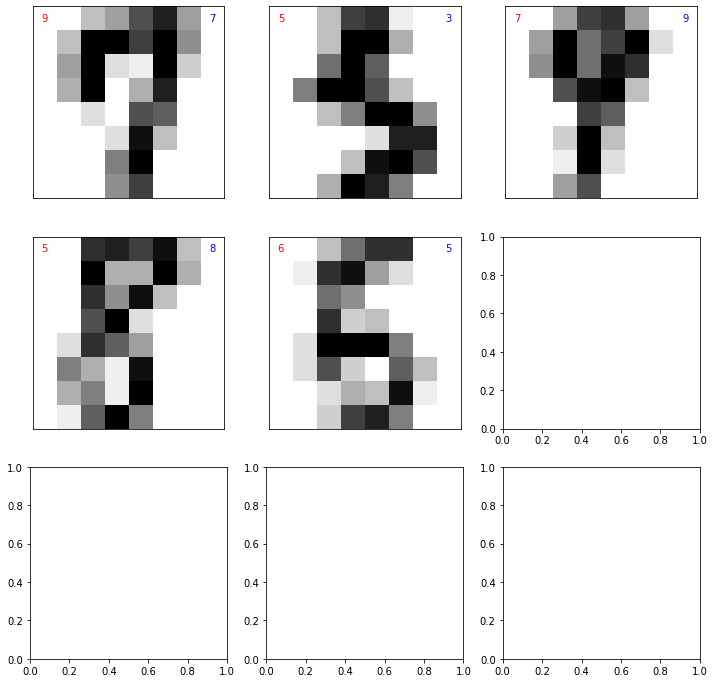

In [56]:
mostar_resultados(digits,model = modelo3 ,nx=3, ny=3,label = "incorrectos")

El valor predicho y el original son distintos cuando no se logra distinguir bien la imagen, es decir, un número tiene dos o más posibles casos

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.

## II.- California Housing Prices


<img src="https://www.wartsila.com/images/default-source/default-album/california_housing.tmb-1920x690.jpg?sfvrsn=126bc44_1" width="480" height="240" align="center"/>

Los datos se refieren a las casas encontradas en un distrito determinado de California y algunas estadísticas resumidas sobre ellas basadas en los datos del censo de 1990. Tenga en cuenta que los datos no se limpian, por lo que se requieren algunos pasos de procesamiento previo.

Las columnas son las siguientes, sus nombres se explican por sí mismos:

* longitude
* latitude
* housingmedianage
* total_rooms
* total_bedrooms
* population
* households
* median_income
* medianhousevalue
* ocean_proximity


El objetivo es poder predecir el valor promedio de cada propiedad. 
Para poder completar correctamente este laboratorio, es necesario seguir la siguiente rúbrica de trabajo:

1. Definición del problema
2. Estadística descriptiva
3. Visualización descriptiva
4. Preprocesamiento
5. Selección de modelo 
    1. Por lo menos debe comparar cuatro modelos
    2. Al menos tres de estos modelos tienen que tener hiperparámetros.
    3. Realizar optimización de hiperparámetros.
6. Métricas y análisis de resultados
7. Visualizaciones del modelo
8. Conclusiones

> **Observación**: Puede tomar como referencia lo realizado en la sección **I.- Clasificación de dígitos**. El alumno tiene la libertad de desarrollar un análisis más completo del problema (si así lo desea). Puede tomar como referencia el siguiente [link](https://www.kaggle.com/camnugent/california-housing-prices).

In [57]:
# read data
housing = pd.read_csv('data/housing.csv',sep=',')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


**1.- Definición del problema**

Se cuenta con data set que contiene información de las casas en un distrito de California, la pregunta más relevante es ¿Cómo se puede predecir el valor medio de una casa?
para esto es necesario procesar nuestro data set, identificar outliers y crear un modelo con la libreria Sklearn.

**2.- Estadística descriptiva**

In [58]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [59]:
# columnas con datos faltantes
housing[housing.isnull().any(axis=1)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,NEAR OCEAN
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,NEAR OCEAN
20372,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN
20460,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0,<1H OCEAN


In [60]:
# estadística
housing.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


In [61]:
housing.shape

(20640, 10)

Vemos que el data tiene 20640 filas y 10 columnas

**3.- Visualización descriptiva**

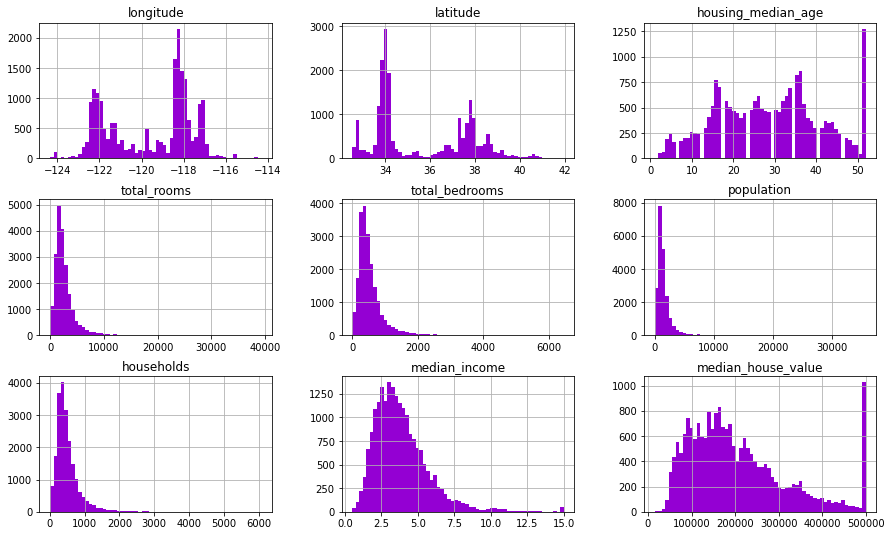

In [62]:
housing.hist(bins=60, figsize=(15,9),color='darkviolet')
plt.show()

Se evidencia la presencia de algunos outlier, como en el gráfico de median_house_value y age. La variable median_house_age también tiene ciertas discontinuidades. Se puede notar cierta distribución en algunas variables, especialmente las últimas 6. Las variables rooms y bedrooms están muy relacionadas.

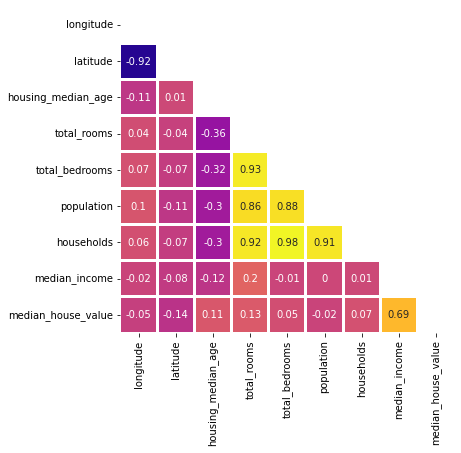

In [63]:
# Veamos la matriz de correlación
def corrMat(df,id=False):
    
    corr_mat = df.corr().round(2)
    f, ax = plt.subplots(figsize=(6,6))
    mask = np.zeros_like(corr_mat,dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_mat,mask=mask,vmin=-1,vmax=1,center=0, 
                cmap='plasma',square=False,lw=2,annot=True,cbar=False);plt.show()  
corrMat(housing) 

La variable median_house_value está levemente correlacionada con todas las características, excepto median_income. Existen variables muy correlacionadas entre si, por ejemplo entre total_bedrooms, population y household.

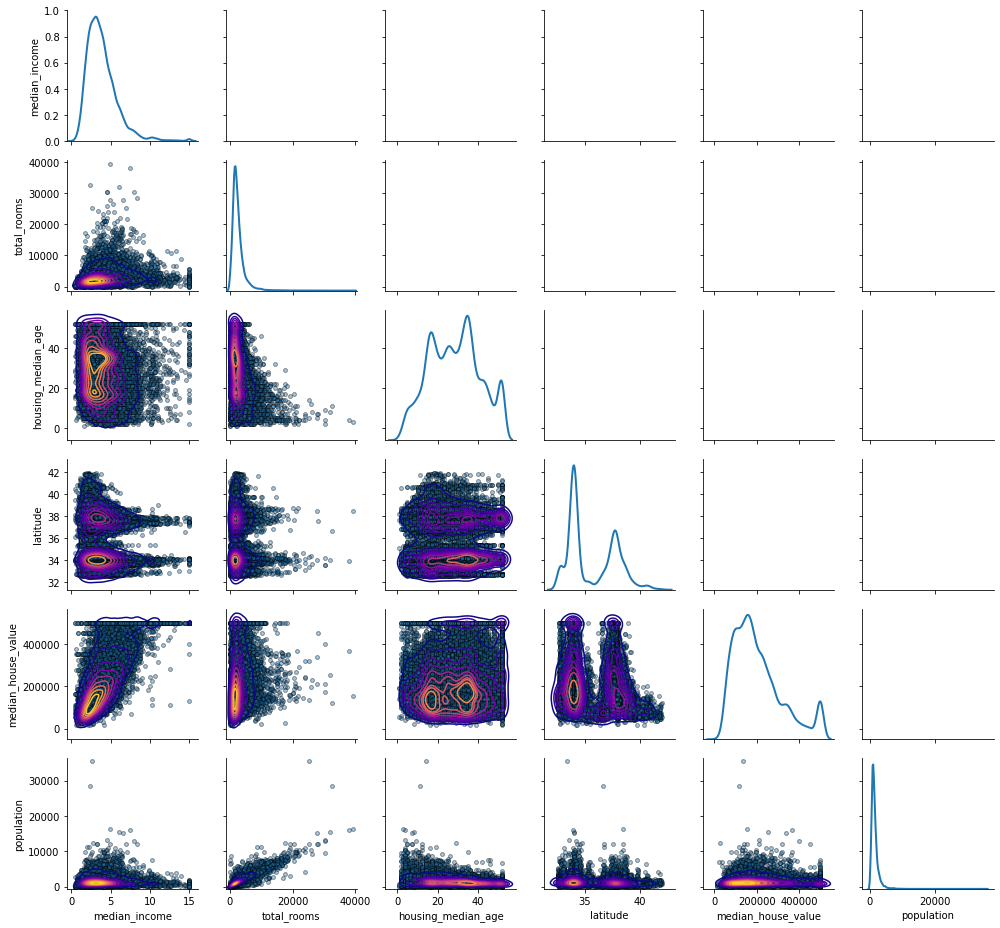

In [64]:
def snsPairGrid(df):

    ''' Plots a Seaborn Pairgrid w/ KDE & scatter plot of df features'''
    g = sns.PairGrid(df,diag_sharey=False)
    g.fig.set_size_inches(14,13)
    g.map_diag(sns.kdeplot, lw=2) # draw kde approximation on the diagonal
    g.map_lower(sns.scatterplot,s=15,edgecolor="k",linewidth=1,alpha=0.4) # scattered plot on lower half
    g.map_lower(sns.kdeplot,cmap='plasma',n_levels=10) # kde approximation on lower half
    plt.tight_layout()
# Seaborn get a little slow, let's plot some interesting features
tlist = ['median_income','total_rooms','housing_median_age','latitude','median_house_value','population']
snsPairGrid(housing[tlist]) 

Diagramas de dispresión, se puede utilizar para encontrar visualmente algunas correlaciones entre variables.
Las variables median_house_value y median_income parecen tener buena relación, al igual que population con median_income.
Otras variables como median_house_value y housing_median_age están muy dispersos entre si.

A continuación, veamos mapas geoespaciales.

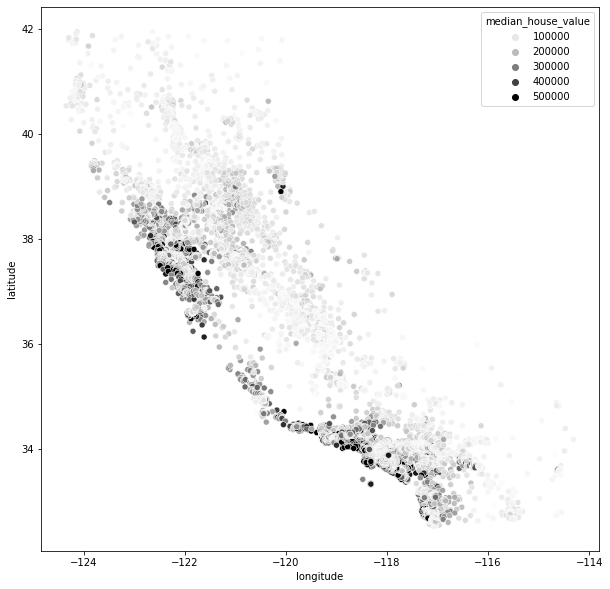

In [65]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=housing.longitude, y=housing.latitude, hue=housing["median_house_value"], palette='Greys')
plt.show()

En el mapa se ven zonas muy intensas, hacía al izquierda de california se encuentra el mar, vemos que existe un gran número de casas cerca del mar.

**4.- Preprocesamiento**

Remover outliers

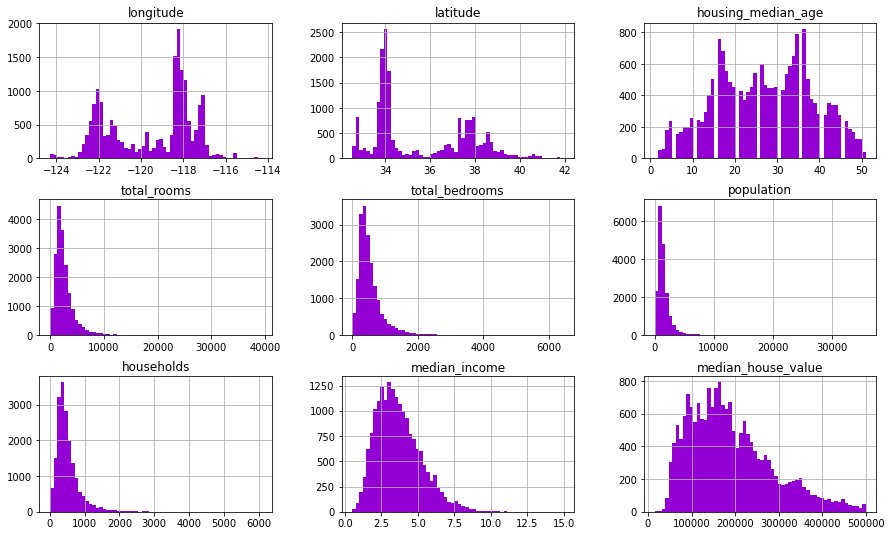

In [66]:
maxval2 = housing['median_house_value'].max() # borra el valor máximo de costo de la casa
housing = housing[housing['median_house_value'] != maxval2] 

maxage2 = housing['housing_median_age'].max() # borra el valor maximo de la edad
housing = housing[housing['housing_median_age'] != maxage2] 

housing.hist(bins=60, figsize=(15,9),color='darkviolet')
plt.show() 




In [67]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        193
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [68]:
housing = housing.dropna()
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

Es necesario escribir las variables de la columna "ocean_proximity" a variables numéricas

In [69]:
housing['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [70]:
housing["ocean_proximity"] = housing["ocean_proximity"].replace({'NEAR BAY':1,'<1H OCEAN':2,'INLAND':3,'NEAR OCEAN':4,'ISLAND':5}) # target 
housing["ocean_proximity"].head()

0     1
1     1
8     1
15    1
18    1
Name: ocean_proximity, dtype: int64

**5.- Selección de modelos**

In [81]:
from metrics_regression import *
from sklearn.metrics import r2_score
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn import linear_model


In [72]:
# estandarización de las variables
X = housing.drop(columns="median_house_value").values
Y = housing["median_house_value"].values
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [73]:
# conjunto de entrenamiento y testeo
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=43)

Comentario: El modelo Logistic regression y SVC tardaban mucho en correr, no fueron considerados

Modelo KNeighbors

In [74]:
model1 = KNeighborsClassifier()

param_grid1 = {
          'n_neighbors':[1,10,100,120,150,170,300,500]}
gs_m1 = GridSearchCV(estimator=model1, # Hiperparámetro
                  param_grid=param_grid1)
gs_m1 = gs_m1.fit(X_train, Y_train)

Modelo Lasso

In [75]:
model2 = Lasso()

param_grid2 = {'alpha':[10,50,100,200,500]}
gs_m2 = GridSearchCV(estimator=model2, # optimización Hiperparámetro
                  param_grid=param_grid2)
gs_m2 = gs_m2.fit(X_train, Y_train)

Modelo Decision Tree Regressor

In [76]:
from sklearn.tree import DecisionTreeRegressor

model3 = DecisionTreeRegressor()
param_grid3 = {'max_depth': [0.01,0.7,1,7,10,50], 
          'max_features': ['auto', 'sqrt'], 
          'min_samples_leaf': [0.01,0.7,1,7,10,50], 
          'min_samples_split': [0.01,0.7,1,7,10,50],
          'criterion': ['mse'] 
         }
gs_m3 = GridSearchCV(estimator=model3, 
                  param_grid=param_grid3)
gs_m3 = gs_m3.fit(X_train, Y_train)

Modelo Bayeasiano (BayesianRidge)

In [85]:
model4 = linear_model.BayesianRidge()
gs_m4 = model4.fit(X_train, Y_train)


**6.- Métricas y análisis del resultado**

Modelo 1: Kneighbors

In [86]:
print("Best: %f con %s" % (gs_m1.best_score_, gs_m1.best_params_))
modelo1 = gs_m1.best_estimator_
print('Precisión: {0:.3f}'.format(modelo1.score(X_test, Y_test)))

Best: 0.006063 con {'n_neighbors': 170}
Precisión: 0.004


In [87]:
Y_pred1 = modelo1.predict(X_test)
df1 = pd.DataFrame(
    {
        'y': Y_test,
        'yhat': Y_pred1
    }
)
df_metrics1 = summary_metrics(df1)
df_metrics1['r2'] =  round(r2_score(Y_test, Y_pred1),4)
df_metrics1

,mae,mse,rmse,mape,maape,wmape,mmape,smape,r2
0,59527.0584,7.234836e+09,85057.8417,0.2923,0.2704,0.3144,0.2923,0.3319,0.1904


Modelo Lasso

In [88]:
print("Best: %f con %s" % (gs_m2.best_score_, gs_m2.best_params_))
modelo2 = gs_m2.best_estimator_
print('Precisión: {0:.3f}'.format(modelo2.score(X_test, Y_test)))

Best: 0.607230 con {'alpha': 50}
Precisión: 0.602


In [89]:
Y_pred2 = modelo2.predict(X_test)
df2 = pd.DataFrame(
    {
        'y': Y_test,
        'yhat': Y_pred2
    }
)
df_metrics2 = summary_metrics(df2)
df_metrics2['r2'] =  round(r2_score(Y_test, Y_pred2),4)
df_metrics2

,mae,mse,rmse,mape,maape,wmape,mmape,smape,r2
0,44457.1579,3.555672e+09,59629.4518,0.2831,0.2546,0.2348,0.2831,0.2624,0.6021


Modelo Decision Tree Regressor

In [90]:
print("Best: %f con %s" % (gs_m3.best_score_, gs_m3.best_params_))
modelo3 = gs_m3.best_estimator_
print('Precisión: {0:.3f}'.format(modelo3.score(X_test, Y_test)))

Best: 0.687424 con {'criterion': 'mse', 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 50}
Precisión: 0.707


In [91]:
Y_pred3 = modelo3.predict(X_test)
df3 = pd.DataFrame(
    {
        'y': Y_test,
        'yhat': Y_pred3
    }
)
df_metrics3 = summary_metrics(df3)
df_metrics3['r2'] =  round(r2_score(Y_test, Y_pred3),4)
df_metrics3

,mae,mse,rmse,mape,maape,wmape,mmape,smape,r2
0,35333.7074,2.619520e+09,51181.2421,0.2058,0.1888,0.1866,0.2058,0.19,0.7069


Modelo Bayeasiano (BayesianRidge)

In [94]:
modelo4 = model4
print('Precisión: {0:.3f}'.format(modelo4.score(X_test, Y_test)))

Precisión: 0.602


In [95]:
Y_pred4 = modelo4.predict(X_test)
df4 = pd.DataFrame(
    {
        'y': Y_test,
        'yhat': Y_pred4
    }
)
df_metrics4 = summary_metrics(df4)
df_metrics4['r2'] =  round(r2_score(Y_test, Y_pred4),4)
df_metrics4

,mae,mse,rmse,mape,maape,wmape,mmape,smape,r2
0,44447.8967,3.554813e+09,59622.2512,0.2831,0.2545,0.2347,0.2831,0.2625,0.6022


**7.- Visualización del modelo**

Modelo 1: Kneighbors

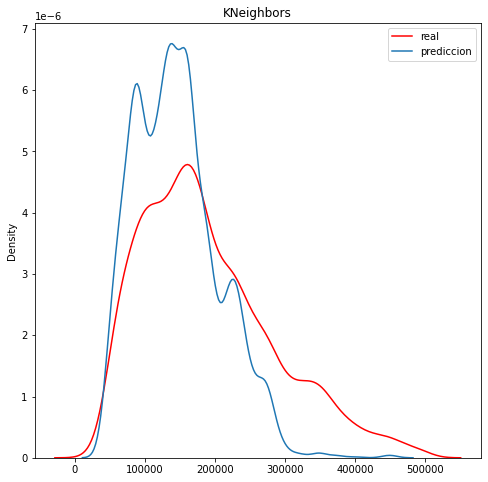

In [96]:
plt.figure(figsize=(8, 8))

ax = sns.distplot(Y_test, hist=False, color="red", label="real")
sns.distplot(Y_pred1, hist=False, label="prediccion" , ax=ax)
plt.title('KNeighbors')
plt.legend()
plt.show()

Modelo Lasso

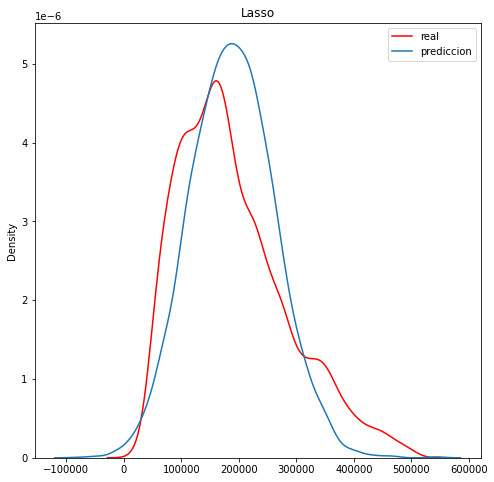

In [97]:
plt.figure(figsize=(8, 8))

ax = sns.distplot(Y_test, hist=False, color="red", label="real")
sns.distplot(Y_pred2, hist=False, label="prediccion" , ax=ax)
plt.title('Lasso')
plt.legend()
plt.show()

Modelo Decision Tree Regressor

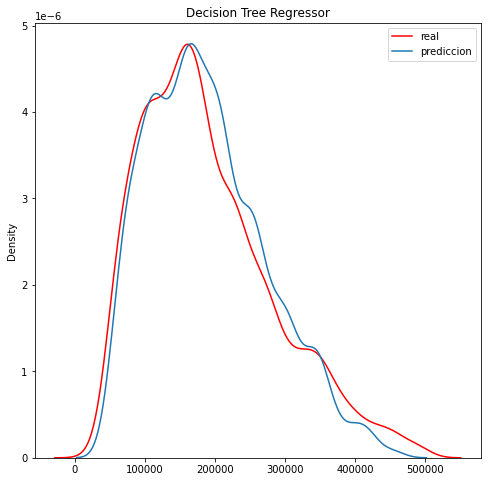

In [100]:
plt.figure(figsize=(8, 8))

ax = sns.distplot(Y_test, hist=False, color="red", label="real")
sns.distplot(Y_pred3, hist=False, label="prediccion" , ax=ax)
plt.title('Decision Tree Regressor')
plt.legend()
plt.show()

Modelo Bayeasiano (BayesianRidge)

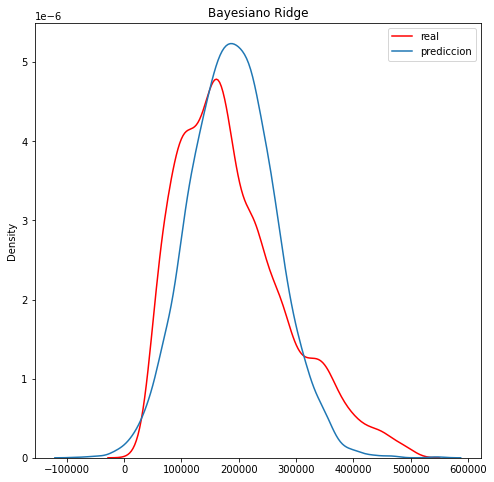

In [101]:
plt.figure(figsize=(8, 8))

ax = sns.distplot(Y_test, hist=False, color="red", label="real")
sns.distplot(Y_pred4, hist=False, label="prediccion" , ax=ax)
plt.title('Bayesiano Ridge')
plt.legend()
plt.show()

**8.- Conclusiones**

In [103]:
modelos = pd.concat([df_metrics1,df_metrics2,df_metrics3,df_metrics4])
modelos["Model"]=['Kneighbors','Lasso','Decision Tree Regressor','Bayesiano Ridge']
modelos.sort_values(['mae','mse'])

,mae,mse,rmse,mape,maape,wmape,mmape,smape,r2,Model
0,35333.7074,2.619520e+09,51181.2421,0.2058,0.1888,0.1866,0.2058,0.1900,0.7069,Decision Tree Regressor
0,44447.8967,3.554813e+09,59622.2512,0.2831,0.2545,0.2347,0.2831,0.2625,0.6022,Bayesiano Ridge
0,44457.1579,3.555672e+09,59629.4518,0.2831,0.2546,0.2348,0.2831,0.2624,0.6021,Lasso
0,59527.0584,7.234836e+09,85057.8417,0.2923,0.2704,0.3144,0.2923,0.3319,0.1904,Kneighbors


Vemos que al ordenar las métricas, se encuentra que el mejor modelo es el de árbol de decisión, con un R2  de 0.7069 y precision de 0.707.